In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
import random
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# import shap
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

Data prep

In [ ]:
data = pd.read_csv('df_data (1).csv', sep=";")
data.head(5)

<ipython-input-2-c7226d78dde0>:1: DtypeWarning: Columns (11,14,20,23,31,33,41,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('df_data (1).csv', sep=";")


,date,time,Жажда,кофеин,startAnswering,Зевания,Тревога,ГБ новая,Алкоголь,Депрессия,...,заметил провокатор,усиление движением,Продолжительность сна,чувствительность к звуку,чувствительность к свету,чувствительность к запахам,ГБ продолжение,Окончание боли,комментарий,какой триггер
0,2023-01-25,15:00,да,да,1674640902,нет,1,нет,нет,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-25,21:00,нет,нет,1674662469,нет,1,нет,нет,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-26,10:00,да,нет,1674710845,нет,1,да,нет,2,...,нет,да,06:30,да,нет,нет,NaN,NaN,NaN,NaN
3,2023-01-26,15:00,да,нет,1674727248,нет,1,NaN,нет,1,...,NaN,NaN,NaN,NaN,NaN,NaN,да,10:00,NaN,NaN
4,2023-01-26,21:00,нет,нет,1674749597,нет,1,нет,нет,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
data["ГБ новая"] = data["ГБ новая"].replace({'да': 1, 'нет': 0})

In [ ]:
data["ГБ новая"]

0        0.0
1        0.0
2        1.0
3        NaN
4        0.0
        ... 
34826    1.0
34827    NaN
34828    1.0
34829    1.0
34830    NaN
Name: ГБ новая, Length: 34831, dtype: float64

In [ ]:
data_not_import = data[["startAnswering", "id", "комментарий"]]
data = data.drop(columns=["startAnswering", "id", "комментарий"], axis=1)

In [ ]:
categorical_columns = ["Название", "какой день", "какой триггер", "односторонняя",
                       "сыр, шоко, цитрус", "Физическая ативность", "Продолжительность сна", "Начало боли", "Окончание боли"]
binary_columns = ['аура', 'Жажда', 'кофеин', 'Зевания', 'тошнота', 'ГБ новая', 'Алкоголь',
                  "Перелеты", "боль в шее","пульсация", "вегетатика", "подташнивает",
                  "Обезболивающее", "мочеиспускание", "Напряжение глаз", "Воды достаточно?", "1 день менструации", "Были резкие запахи?",
                  "заметил провокатор", "усиление движением", "Пропуск приема пищи", "Чувствит кожи головы", "Сложность концентрации",
                  "Больше света, чем обычно", "чувствительность к звуку", "чувствительность к свету", "чувствительность к запахам",
                  "ГБ продолжение", "Хотелось шоколада", "Больше звука чем обычно"]
quantitative_columns = ["Тревога", "ВАШ макс", "Депрессия", "Сонливость", "Чувство голода", "Ожидаете мигрень", "Работосособность",
                     "Чувство усталости", "Раздражительность", "Качество сна", "Свежесть после сна", "% заполнения дневника",
                        "Чувствительность к звуку", "Чувствительность к свету", "Чувствительность к запахам"
                        ]
time_data =['time']
date_data = ["date"]

In [ ]:
longest_string_index = data[['time', "Начало боли", "Продолжительность сна", "Окончание боли"]].apply(lambda x: ''.join(x.astype(str)), axis=1).str.len().idxmax()
longest_string = data.loc[longest_string_index, ['time', "Начало боли", "Продолжительность сна", "Окончание боли"]]
longest_string

time                                                                10:00
Начало боли                                                           NaN
Продолжительность сна    Сложно оценить, т.к просыпалась каждые 30-40 мин
Окончание боли                                                        NaN
Name: 33545, dtype: object

In [ ]:
data = data.drop(columns=["Боль сейчас"], axis=1)
data = data.drop(data.iloc[:, 27:58],axis = 1)
data = data.drop(columns=["Ожидаете мигрень"], axis=1)

In [ ]:
categorical_columns = [
                       "сыр, шоко, цитрус", "Физическая ативность", ]
binary_columns = ['Жажда', 'кофеин', 'Зевания', 'ГБ новая', 'Алкоголь'
                  , "боль в шее", "вегетатика", "подташнивает",
                   "мочеиспускание", "Напряжение глаз", "Воды достаточно?", "Были резкие запахи?",
                    "Пропуск приема пищи", "Чувствит кожи головы",
                   "Хотелось шоколада"]
quantitative_columns = ["Тревога", "Депрессия", "Сонливость", "Чувство голода",
                        "Работосособность", "Чувство усталости", "Раздражительность"

                        ]
time_data =['time']
date_data = ["date"]

In [ ]:
mode_values = data.mode().iloc[0]

# Fill NaN values with mode values in all columns
data = data.fillna(mode_values)
data

,date,time,Жажда,кофеин,Зевания,Тревога,ГБ новая,Алкоголь,Депрессия,боль в шее,...,Воды достаточно?,"сыр, шоко, цитрус",Работосособность,Хотелось шоколада,Чувство усталости,Раздражительность,Были резкие запахи?,Пропуск приема пищи,Чувствит кожи головы,Физическая ативность
0,2023-01-25,15:00,да,да,нет,1,0.0,нет,1,да,...,да,нет,1,да,2,1,нет,нет,нет,совсем нет
1,2023-01-25,21:00,нет,нет,нет,1,0.0,нет,1,нет,...,да,нет,3,нет,3,1,нет,нет,нет,слабо
2,2023-01-26,10:00,да,нет,нет,1,1.0,нет,2,да,...,да,нет,2,нет,2,2,да,нет,да,совсем нет
3,2023-01-26,15:00,да,нет,нет,1,0.0,нет,1,да,...,да,нет,1,да,2,1,нет,нет,да,совсем нет
4,2023-01-26,21:00,нет,нет,нет,1,0.0,нет,1,нет,...,да,нет,3,нет,3,1,нет,нет,нет,совсем нет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34826,2021-03-17,15:00,да,да,нет,3,1.0,да,3,нет,...,да,да,3,да,5,3,нет,да,нет,совсем нет
34827,2021-08-16,10:00,нет,да,нет,2,0.0,нет,3,да,...,да,да,3,да,4,4,нет,да,нет,слабо
34828,2021-08-16,21:00,да,да,да,3,1.0,нет,3,да,...,да,да,4,да,5,2,нет,нет,да,слабо
34829,2021-08-18,15:00,да,да,нет,3,1.0,нет,3,да,...,да,да,3,нет,4,4,нет,нет,нет,слабо


In [ ]:
data["ГБ новая"] = data["ГБ новая"].astype(int)

In [ ]:
data

,date,time,Жажда,кофеин,Зевания,Тревога,ГБ новая,Алкоголь,Депрессия,боль в шее,...,Воды достаточно?,"сыр, шоко, цитрус",Работосособность,Хотелось шоколада,Чувство усталости,Раздражительность,Были резкие запахи?,Пропуск приема пищи,Чувствит кожи головы,Физическая ативность
0,2023-01-25,15:00,да,да,нет,1,0,нет,1,да,...,да,нет,1,да,2,1,нет,нет,нет,совсем нет
1,2023-01-25,21:00,нет,нет,нет,1,0,нет,1,нет,...,да,нет,3,нет,3,1,нет,нет,нет,слабо
2,2023-01-26,10:00,да,нет,нет,1,1,нет,2,да,...,да,нет,2,нет,2,2,да,нет,да,совсем нет
3,2023-01-26,15:00,да,нет,нет,1,0,нет,1,да,...,да,нет,1,да,2,1,нет,нет,да,совсем нет
4,2023-01-26,21:00,нет,нет,нет,1,0,нет,1,нет,...,да,нет,3,нет,3,1,нет,нет,нет,совсем нет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34826,2021-03-17,15:00,да,да,нет,3,1,да,3,нет,...,да,да,3,да,5,3,нет,да,нет,совсем нет
34827,2021-08-16,10:00,нет,да,нет,2,0,нет,3,да,...,да,да,3,да,4,4,нет,да,нет,слабо
34828,2021-08-16,21:00,да,да,да,3,1,нет,3,да,...,да,да,4,да,5,2,нет,нет,да,слабо
34829,2021-08-18,15:00,да,да,нет,3,1,нет,3,да,...,да,да,3,нет,4,4,нет,нет,нет,слабо


In [ ]:
target = data["ГБ новая"]

In [ ]:
y = data["ГБ новая"].values

In [ ]:
data = data.drop(columns = ["ГБ новая"], axis=1)

In [ ]:
binary_columns = ['Жажда', 'кофеин', 'Зевания',  'Алкоголь'
                  , "боль в шее", "вегетатика", "подташнивает",
                   "мочеиспускание", "Напряжение глаз", "Воды достаточно?", "Были резкие запахи?",
                    "Пропуск приема пищи", "Чувствит кожи головы",
                   "Хотелось шоколада"]

In [ ]:
for column in binary_columns:
    data[column] = data[column].replace({'да': 1, 'нет': 0})

In [ ]:
for column in time_data:
    data[column] = pd.to_datetime(data[column], format='%H:%M')

for column in time_data:
    time_components = [f'{column}_hour', f'{column}_minute']

    data[time_components] = data[column].apply(lambda x: pd.Series([x.hour, x.minute]))
    data_encoded = pd.get_dummies(data, columns=time_components)

In [ ]:
data

,date,time,Жажда,кофеин,Зевания,Тревога,Алкоголь,Депрессия,боль в шее,Сонливость,...,Работосособность,Хотелось шоколада,Чувство усталости,Раздражительность,Были резкие запахи?,Пропуск приема пищи,Чувствит кожи головы,Физическая ативность,time_hour,time_minute
0,2023-01-25,1900-01-01 15:00:00,1,1,0,1,0,1,1,3,...,1,1,2,1,0,0,0,совсем нет,15,0
1,2023-01-25,1900-01-01 21:00:00,0,0,0,1,0,1,0,3,...,3,0,3,1,0,0,0,слабо,21,0
2,2023-01-26,1900-01-01 10:00:00,1,0,0,1,0,2,1,2,...,2,0,2,2,1,0,1,совсем нет,10,0
3,2023-01-26,1900-01-01 15:00:00,1,0,0,1,0,1,1,2,...,1,1,2,1,0,0,1,совсем нет,15,0
4,2023-01-26,1900-01-01 21:00:00,0,0,0,1,0,1,0,3,...,3,0,3,1,0,0,0,совсем нет,21,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34826,2021-03-17,1900-01-01 15:00:00,1,1,0,3,1,3,0,2,...,3,1,5,3,0,1,0,совсем нет,15,0
34827,2021-08-16,1900-01-01 10:00:00,0,1,0,2,0,3,1,4,...,3,1,4,4,0,1,0,слабо,10,0
34828,2021-08-16,1900-01-01 21:00:00,1,1,1,3,0,3,1,4,...,4,1,5,2,0,0,1,слабо,21,0
34829,2021-08-18,1900-01-01 15:00:00,1,1,0,3,0,3,1,5,...,3,0,4,4,0,0,0,слабо,15,0


In [ ]:
data = pd.get_dummies(data, columns=categorical_columns+quantitative_columns+binary_columns)

In [ ]:
data

,date,time,time_hour,time_minute,"сыр, шоко, цитрус_да","сыр, шоко, цитрус_нет",Физическая ативность_Слабо,Физическая ативность_да,Физическая ативность_интенсивная,Физическая ативность_интенсивно,...,Воды достаточно?_0,Воды достаточно?_1,Были резкие запахи?_0,Были резкие запахи?_1,Пропуск приема пищи_0,Пропуск приема пищи_1,Чувствит кожи головы_0,Чувствит кожи головы_1,Хотелось шоколада_0,Хотелось шоколада_1
0,2023-01-25,1900-01-01 15:00:00,15,0,0,1,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,2023-01-25,1900-01-01 21:00:00,21,0,0,1,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
2,2023-01-26,1900-01-01 10:00:00,10,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,1,0
3,2023-01-26,1900-01-01 15:00:00,15,0,0,1,0,0,0,0,...,0,1,1,0,1,0,0,1,0,1
4,2023-01-26,1900-01-01 21:00:00,21,0,0,1,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34826,2021-03-17,1900-01-01 15:00:00,15,0,1,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,1
34827,2021-08-16,1900-01-01 10:00:00,10,0,1,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,1
34828,2021-08-16,1900-01-01 21:00:00,21,0,1,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,1
34829,2021-08-18,1900-01-01 15:00:00,15,0,1,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0


In [ ]:
data.iloc[:, 0:2]

,date,time
0,2023-01-25,1900-01-01 15:00:00
1,2023-01-25,1900-01-01 21:00:00
2,2023-01-26,1900-01-01 10:00:00
3,2023-01-26,1900-01-01 15:00:00
4,2023-01-26,1900-01-01 21:00:00
...,...,...
34826,2021-03-17,1900-01-01 15:00:00
34827,2021-08-16,1900-01-01 10:00:00
34828,2021-08-16,1900-01-01 21:00:00
34829,2021-08-18,1900-01-01 15:00:00


In [ ]:
import pandas as pd

# Assuming your data is stored in a DataFrame called "df"
data["time"] = pd.to_datetime(data["time"]).dt.time


In [ ]:
data

,date,time,time_hour,time_minute,"сыр, шоко, цитрус_да","сыр, шоко, цитрус_нет",Физическая ативность_Слабо,Физическая ативность_да,Физическая ативность_интенсивная,Физическая ативность_интенсивно,...,Воды достаточно?_0,Воды достаточно?_1,Были резкие запахи?_0,Были резкие запахи?_1,Пропуск приема пищи_0,Пропуск приема пищи_1,Чувствит кожи головы_0,Чувствит кожи головы_1,Хотелось шоколада_0,Хотелось шоколада_1
0,2023-01-25,15:00:00,15,0,0,1,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,2023-01-25,21:00:00,21,0,0,1,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
2,2023-01-26,10:00:00,10,0,0,1,0,0,0,0,...,0,1,0,1,1,0,0,1,1,0
3,2023-01-26,15:00:00,15,0,0,1,0,0,0,0,...,0,1,1,0,1,0,0,1,0,1
4,2023-01-26,21:00:00,21,0,0,1,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34826,2021-03-17,15:00:00,15,0,1,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,1
34827,2021-08-16,10:00:00,10,0,1,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,1
34828,2021-08-16,21:00:00,21,0,1,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,1
34829,2021-08-18,15:00:00,15,0,1,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0


In [ ]:
data.columns

Index(['date', 'time', 'time_hour', 'time_minute', 'сыр, шоко, цитрус_да',
       'сыр, шоко, цитрус_нет', 'Физическая ативность_Слабо',
       'Физическая ативность_да', 'Физическая ативность_интенсивная',
       'Физическая ативность_интенсивно',
       ...
       'Воды достаточно?_0', 'Воды достаточно?_1', 'Были резкие запахи?_0',
       'Были резкие запахи?_1', 'Пропуск приема пищи_0',
       'Пропуск приема пищи_1', 'Чувствит кожи головы_0',
       'Чувствит кожи головы_1', 'Хотелось шоколада_0', 'Хотелось шоколада_1'],
      dtype='object', length=113)

In [ ]:

# Convert "date" and "time" columns to a single datetime column
data["datetime"] = pd.to_datetime(data["date"] + " " + data["time"].astype(str))

# Set the datetime column as the index
# data.set_index("datetime", inplace=True)

# Drop unnecessary columns
data.drop(["date", "time", "datetime"], axis=1, inplace=True)


In [ ]:
data

,time_hour,time_minute,"сыр, шоко, цитрус_да","сыр, шоко, цитрус_нет",Физическая ативность_Слабо,Физическая ативность_да,Физическая ативность_интенсивная,Физическая ативность_интенсивно,Физическая ативность_нет,Физическая ативность_слабо,...,Воды достаточно?_0,Воды достаточно?_1,Были резкие запахи?_0,Были резкие запахи?_1,Пропуск приема пищи_0,Пропуск приема пищи_1,Чувствит кожи головы_0,Чувствит кожи головы_1,Хотелось шоколада_0,Хотелось шоколада_1
0,15,0,0,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,21,0,0,1,0,0,0,0,0,1,...,0,1,1,0,1,0,1,0,1,0
2,10,0,0,1,0,0,0,0,0,0,...,0,1,0,1,1,0,0,1,1,0
3,15,0,0,1,0,0,0,0,0,0,...,0,1,1,0,1,0,0,1,0,1
4,21,0,0,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34826,15,0,1,0,0,0,0,0,0,0,...,0,1,1,0,0,1,1,0,0,1
34827,10,0,1,0,0,0,0,0,0,1,...,0,1,1,0,0,1,1,0,0,1
34828,21,0,1,0,0,0,0,0,0,1,...,0,1,1,0,1,0,0,1,0,1
34829,15,0,1,0,0,0,0,0,0,1,...,0,1,1,0,1,0,1,0,1,0


In [ ]:
# import pandas as pd
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split


# # Normalize the input features
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data.values)

# X = data.iloc[:, 2:].values
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Convert the data to PyTorch tensors
# X_train_tensor = torch.from_numpy(X_train).float()
# X_test_tensor = torch.from_numpy(X_test).float()
# y_train_tensor = torch.from_numpy(y_train).long()
# y_test_tensor = torch.from_numpy(y_test).long()

# # Create a TensorDataset and DataLoader for training data
# train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# # Define the LSTM model
# class LSTMModel(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(LSTMModel, self).__init__()
#         self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         out, _ = self.lstm(x)
#         out = self.fc(out[:, -1, :])
#         return out

# # Initialize the model
# input_size = X_train.shape[1]
# hidden_size = 64
# output_size = 1
# model_lstm = LSTMModel(input_size, hidden_size, output_size)

# # Define the loss function and optimizer
# criterion = nn.BCEWithLogitsLoss()
# optimizer = optim.Adam(model_lstm.parameters(), lr=0.001)

# # Train the model
# num_epochs = 10
# model_lstm.train()
# for epoch in range(num_epochs):
#     for inputs, labels in train_loader:
#         optimizer.zero_grad()
#         outputs = model_lstm(inputs.unsqueeze(dim=1))
#         loss = criterion(outputs.squeeze(), labels.float())
#         loss.backward()
#         optimizer.step()

# # Evaluate the model
# model_lstm.eval()
# with torch.no_grad():
#     y_pred_tensor = torch.round(torch.sigmoid(model_lstm(X_test_tensor.unsqueeze(dim=1))))
#     y_pred_lstm = y_pred_tensor.numpy()
#     y_test_np = y_test_tensor.numpy()

# accuracy = accuracy_score(y_test_np, y_pred_lstm)
# print("Accuracy:", accuracy)

In [ ]:
# import plotly.graph_objects as go

# # Perform time series prediction
# model_lstm.eval()
# with torch.no_grad():
#     # Use the trained model to predict on the entire dataset
#     X_tensor = torch.from_numpy(X).float()
#     y_pred_tensor = torch.round(torch.sigmoid(model_lstm(X_tensor.unsqueeze(dim=1))))
#     y_pred_lstm = y_pred_tensor.numpy()

# # Create the scatter plot
# fig = go.Figure()

# # Add the predicted values as scatter points
# fig.add_trace(go.Scatter(
#     x=data.index,
#     y=target,
#     mode="markers",
#     name="Predicted",
#     marker=dict(color="blue")
# ))


# # Set the layout and display the figure
# fig.update_layout(
#     title="Time Series Prediction with LSTM",
#     xaxis=dict(title="Date"),
#     yaxis=dict(title="ГБ новая"),
#     hovermode="x",
#     showlegend=True
# )
# fig.show()


In [ ]:
# # Evaluate the model and generate predictions for the test dataset
# model_lstm.eval()
# with torch.no_grad():
#     y_pred_probs = torch.sigmoid(model_lstm(X_test_tensor.unsqueeze(dim=1)))
#     y_pred_class = torch.round(y_pred_probs)

# # Convert the tensors to numpy arrays
# y_pred_probs_np = y_pred_probs.numpy()
# y_pred_class_np = y_pred_class.numpy()

# # Create a report with the predicted class value and probability for each sample
# report = []
# for i in range(len(X_test)):
#     sample_report = {
#         'Sample': i + 1,
#         'Actual Class': y_test[i],
#         'Predicted Class': y_pred_class_np[i],
#         'Probability': 1 - y_pred_probs_np[i]
#     }
#     report.append(sample_report)

# # Print the report
# for sample_report in report:
#     print(sample_report)


# Other architectures

In [ ]:
X = data.iloc[:, 2:].values


In [ ]:
y

array([0, 0, 1, ..., 1, 1, 0])

In [ ]:
print('X shape', X.shape)
print('y shape', len(y))

X shape (34831, 109)
y shape 34831


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import copy

In [ ]:
device = torch.device("cpu")

<ipython-input-42-0b89fecac6e7>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
<ipython-input-42-0b89fecac6e7>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)


19981
13981
Accuracy (wide): 0.89
Accuracy (wide): 0.89
Accuracy (deep): 0.89
Accuracy (deep): 0.89
Wide: 88.73% (+/- 0.06%)
Deep: 88.82% (+/- 0.00%)
Retrain a deep model
Final model accuracy: 89.26%
[[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1.
  0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0.]] -> 0.2519882619380951 (expected 0.0)
[[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.]] -> 0.042002998292446136 (expected 0.0)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0.

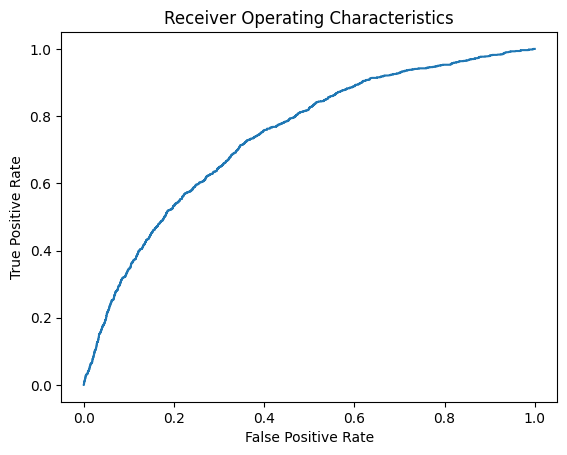

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import copy

# Convert to 2D PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

# Check for GPU availability and set the device
device = torch.device("cpu")

# Move tensors to the GPU
X = X.to(device)
y = y.to(device)

# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(109, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(109, 60)
        self.act1 = nn.ReLU()
        self.layer2 = nn.Linear(60, 60)
        self.act2 = nn.ReLU()
        self.layer3 = nn.Linear(60, 60)
        self.act3 = nn.ReLU()
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.act2(self.layer2(x))
        x = self.act3(self.layer3(x))
        x = self.sigmoid(self.output(x))
        return x

# Compare model sizes
model1 = Wide().to(device)
model2 = Deep().to(device)
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = -np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # move batch to GPU
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        with torch.no_grad():
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            acc = float(acc)
            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Move data tensors to the CPU
X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=2, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide().to(device)
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep().to(device)
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide().to(device)
else:
    print("Retrain a deep model")
    model = Deep().to(device)
acc = model_train(model, X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device))
print(f"Final model accuracy: {acc*100:.2f}%")

model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test[i:i+1].cpu()
        y_pred = model(X_sample)
        print(f"{X_sample.numpy()} -> {y_pred.cpu().detach().numpy()[0][0]} (expected {y_test[i].numpy()[0]})")

    # Plot the ROC curve
    with torch.no_grad():
        y_pred = model(X_test.to(device)).cpu().detach().numpy()
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred)
    plt.plot(fpr, tpr)  # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()


Better than LSTM

In [ ]:
# torch.save(model, f"deep_model.pt")

In [ ]:
# model = torch.load("deep_model.pt")

AttributeError: ignored

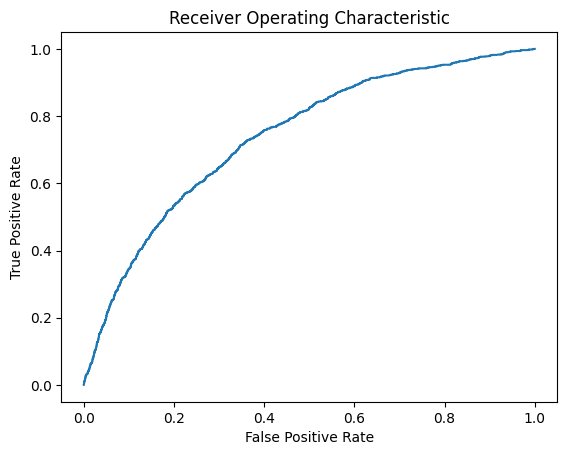

AUC-ROC Score: 0.7399168305034256


In [ ]:
import sklearn.metrics as metrics

# Run the model on the test dataset
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(X_test)
    y_pred = y_pred.cpu().detach().numpy()

# Calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().detach().numpy(), y_pred)

# Calculate AUC-ROC score
auc_score = metrics.roc_auc_score(y_test.cpu().detach().numpy(), y_pred)

# Visualize ROC curve
plt.plot(fpr, tpr)
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Print AUC-ROC score
print("AUC-ROC Score:", auc_score)


Result is the best for now

# Further enhancements

Add dropout

In [ ]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

19981
49561
Accuracy (wide): 0.89
Accuracy (wide): 0.89
Accuracy (wide): 0.89
Accuracy (wide): 0.89
Accuracy (wide): 0.89
Accuracy (deep): 0.89
Accuracy (deep): 0.89
Accuracy (deep): 0.89
Accuracy (deep): 0.89
Accuracy (deep): 0.89
Wide: 88.94% (+/- 0.11%)
Deep: 88.84% (+/- 0.02%)
Retrain a wide model
Final model accuracy: 89.03%
[[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.]] -> 0.032845694571733475 (expected 1.0)
[[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 

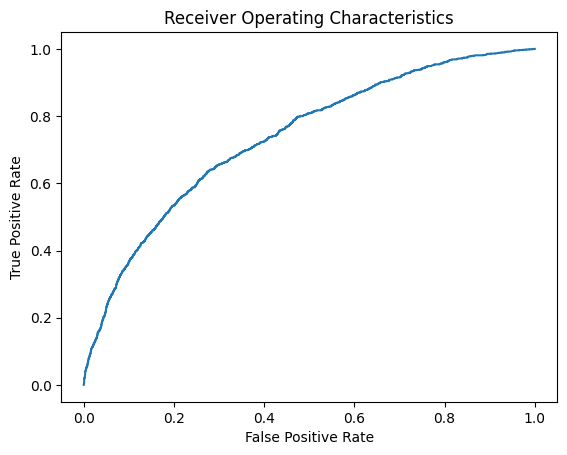

In [ ]:
# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(109, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(109, 120)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(120, 120)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(120, 120)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.layer4 = nn.Linear(120, 60)
        self.act4 = nn.ReLU()
        self.dropout4 = nn.Dropout(0.2)
        self.output = nn.Linear(60, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.act3(self.layer3(x))
        x = self.dropout3(x)
        x = self.act4(self.layer4(x))
        x = self.dropout4(x)
        x = self.sigmoid(self.output(x))
        return x

# Compare model sizes
model1 = Wide().to(device)
model2 = Deep().to(device)
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = -np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # move batch to GPU
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        with torch.no_grad():
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            acc = float(acc)
            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Move data tensors to the CPU
X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=5, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide().to(device)
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep().to(device)
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide().to(device)
else:
    print("Retrain a deep model")
    model = Deep().to(device)
acc = model_train(model, X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device))
print(f"Final model accuracy: {acc*100:.2f}%")

model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test[i:i+1].cpu()
        y_pred = model(X_sample)
        print(f"{X_sample.numpy()} -> {y_pred.cpu().detach().numpy()[0][0]} (expected {y_test[i].numpy()[0]})")

    # Plot the ROC curve
    with torch.no_grad():
        y_pred = model(X_test.to(device)).cpu().detach().numpy()
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred)
    plt.plot(fpr, tpr)  # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()


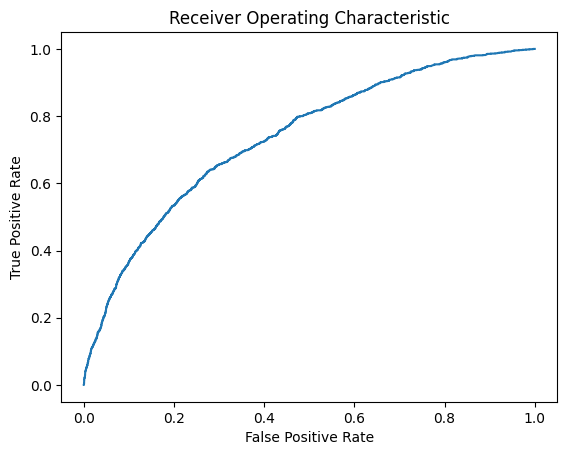

AUC-ROC Score: 0.7363808685487008


In [ ]:
import sklearn.metrics as metrics

# Run the model on the test dataset
model.eval()
with torch.no_grad():
    X_test = X_test.to(device)
    y_test = y_test.to(device)
    y_pred = model(X_test)
    y_pred = y_pred.cpu().detach().numpy()

# Calculate ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().detach().numpy(), y_pred)

# Calculate AUC-ROC score
auc_score = metrics.roc_auc_score(y_test.cpu().detach().numpy(), y_pred)

# Visualize ROC curve
plt.plot(fpr, tpr)
plt.title("Receiver Operating Characteristic")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Print AUC-ROC score
print("AUC-ROC Score:", auc_score)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-38-a8f65fa0f553>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train, y_train)
/us

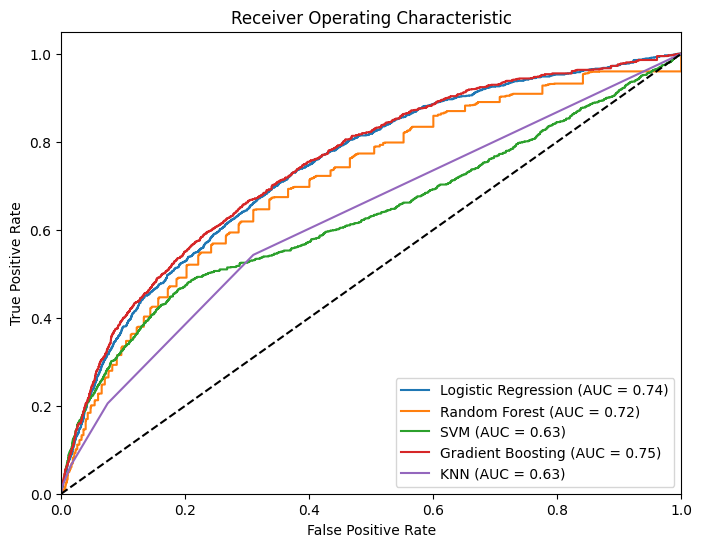

In [ ]:
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()
model_svm = SVC(probability=True)
model_gb = GradientBoostingClassifier()
model_knn = KNeighborsClassifier()

model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_svm.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_knn.fit(X_train, y_train)

probs_lr = model_lr.predict_proba(X_test)[:, 1]
probs_rf = model_rf.predict_proba(X_test)[:, 1]
probs_svm = model_svm.predict_proba(X_test)[:, 1]
probs_gb = model_gb.predict_proba(X_test)[:, 1]
probs_knn = model_knn.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, probs_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probs_rf)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, probs_svm)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, probs_gb)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, probs_knn)

roc_auc_lr = roc_auc_score(y_test, probs_lr)
roc_auc_rf = roc_auc_score(y_test, probs_rf)
roc_auc_svm = roc_auc_score(y_test, probs_svm)
roc_auc_gb = roc_auc_score(y_test, probs_gb)
roc_auc_knn = roc_auc_score(y_test, probs_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', drawstyle='steps-post')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', drawstyle='steps-post')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', drawstyle='steps-post')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})', drawstyle='steps-post')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


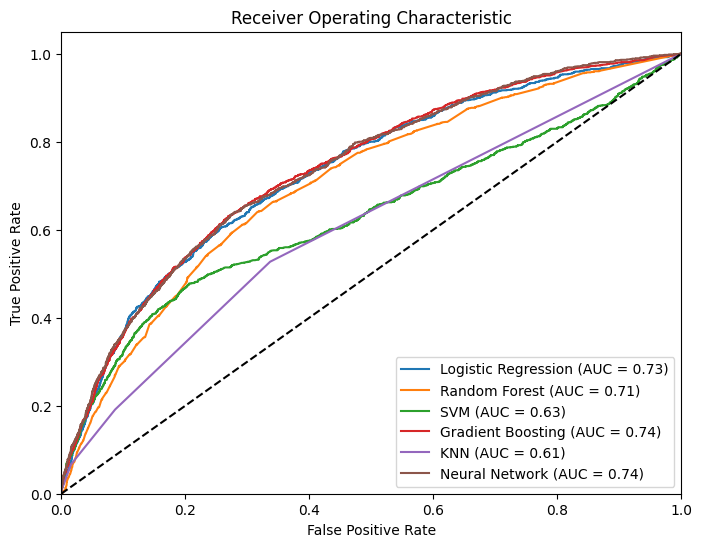

In [ ]:
import sklearn.metrics as metrics

# Initialize the models
models = {
    "Logistic Regression": model_lr,
    "Random Forest": model_rf,
    "SVM": model_svm,
    "Gradient Boosting": model_gb,
    "KNN": model_knn,
    "Neural Network": model
}

# Evaluate and plot the ROC curves for all models
plt.figure(figsize=(8, 6))

for model_name, model in models.items():
    if model_name == "Neural Network":
        # Run the neural network model on the test dataset
        model.eval()
        with torch.no_grad():
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_pred = model(X_test)
            y_pred = y_pred.cpu().detach().numpy()

        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().detach().numpy(), y_pred)

        # Calculate AUC-ROC score
        auc_score = metrics.roc_auc_score(y_test.cpu().detach().numpy(), y_pred)
    else:
        # Predict probabilities using the machine learning model
        model_probs = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model_probs)

        # Calculate AUC-ROC score
        auc_score = metrics.roc_auc_score(y_test, model_probs)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cpu')

In [ ]:
!git clone https://github.com/kyegomez/Sophia.git

Cloning into 'Sophia'...
remote: Enumerating objects: 163, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 163 (delta 2), reused 3 (delta 0), pack-reused 144
Receiving objects: 100% (163/163), 237.20 KiB | 2.96 MiB/s, done.
Resolving deltas: 100% (84/84), done.


In [ ]:
# from Sophia.Sophia import Sophia

ImportError: ignored

In [ ]:
# SophiaG(model.parameters(), lr=2e-4, betas=(0.965, 0.99), rho = 0.01, weight_decay=1e-1)

Add fc + lstm

36721
59351
Accuracy (wide): 0.89
Accuracy (wide): 0.89
Accuracy (deep): 0.89
Accuracy (deep): 0.89
Wide: 88.71% (+/- 0.00%)
Deep: 88.75% (+/- 0.01%)
Retrain a deep model
Final model accuracy: 89.34%
[[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1.
  0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]] -> 0.09303313493728638 (expected 0.0)
[[1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0.]] -> 0.04156503453850746 (expected 0.0)


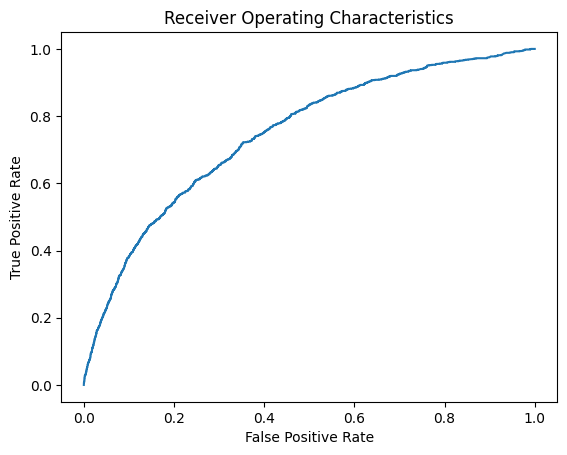

In [ ]:
# Define two models
class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(109, 180)
        self.batch_norm1 = nn.BatchNorm1d(180)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.hidden2 = nn.Linear(180, 90)
        self.batch_norm2 = nn.BatchNorm1d(90)
        self.output = nn.Linear(90, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if x.size(0) != 1:
            x = self.relu(self.batch_norm1(self.hidden1(x)))
            x = self.dropout(x)
            x = self.relu(self.batch_norm2(self.hidden2(x)))
        else:
            x = self.relu(self.hidden1(x))
            x = self.dropout(x)
            x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(109, 150)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(150, 150)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.layer3 = nn.Linear(150, 100)
        self.act3 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.3)
        self.layer4 = nn.Linear(100, 50)
        self.act4 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.3)
        self.output = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.act3(self.layer3(x))
        x = self.dropout3(x)
        x = self.act4(self.layer4(x))
        x = self.dropout4(x)
        x = self.sigmoid(self.output(x))
        return x

# Compare model sizes
model1 = Wide().to(device)
model2 = Deep().to(device)
print(sum([x.reshape(-1).shape[0] for x in model1.parameters()]))  # 11161
print(sum([x.reshape(-1).shape[0] for x in model2.parameters()]))  # 11041

# Helper function to train one model
def model_train(model, X_train, y_train, X_val, y_val):
    # loss function and optimizer
    loss_fn = nn.BCELoss()  # binary cross entropy
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 300   # number of epochs to run
    batch_size = 10  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_acc = -np.inf   # init to negative infinity
    best_weights = None

    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # move batch to GPU
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                acc = (y_pred.round() == y_batch).float().mean()
                bar.set_postfix(
                    loss=float(loss),
                    acc=float(acc)
                )
        # evaluate accuracy at end of each epoch
        model.eval()
        with torch.no_grad():
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            acc = float(acc)
            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return best_acc

# train-test split: Hold out the test set for final model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Move data tensors to the CPU
X_train = X_train.cpu()
y_train = y_train.cpu()
X_test = X_test.cpu()
y_test = y_test.cpu()

# define 5-fold cross validation test harness
kfold = StratifiedKFold(n_splits=2, shuffle=True)
cv_scores_wide = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Wide().to(device)
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (wide): %.2f" % acc)
    cv_scores_wide.append(acc)
cv_scores_deep = []
for train, test in kfold.split(X_train, y_train):
    # create model, train, and get accuracy
    model = Deep().to(device)
    acc = model_train(model, X_train[train], y_train[train], X_train[test], y_train[test])
    print("Accuracy (deep): %.2f" % acc)
    cv_scores_deep.append(acc)

# evaluate the model
wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print("Wide: %.2f%% (+/- %.2f%%)" % (wide_acc*100, wide_std*100))
print("Deep: %.2f%% (+/- %.2f%%)" % (deep_acc*100, deep_std*100))

# rebuild model with full set of training data
if wide_acc > deep_acc:
    print("Retrain a wide model")
    model = Wide().to(device)
else:
    print("Retrain a deep model")
    model = Deep().to(device)
acc = model_train(model, X_train.to(device), y_train.to(device), X_test.to(device), y_test.to(device))
print(f"Final model accuracy: {acc*100:.2f}%")

model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(2):
        X_sample = X_test[i:i+1].cpu()
        y_pred = model(X_sample)
        print(f"{X_sample.numpy()} -> {y_pred.cpu().detach().numpy()[0][0]} (expected {y_test[i].numpy()[0]})")

    # Plot the ROC curve
    with torch.no_grad():
        y_pred = model(X_test.to(device)).cpu().detach().numpy()
    fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred)
    plt.plot(fpr, tpr)  # ROC curve = TPR vs FPR
    plt.title("Receiver Operating Characteristics")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

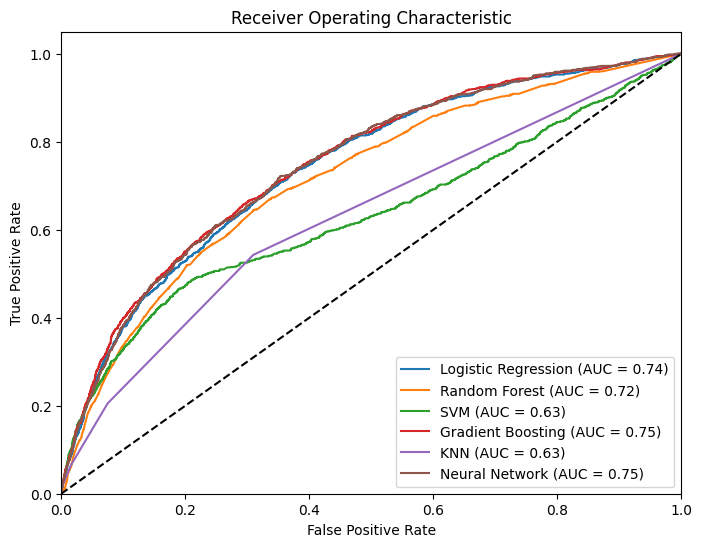

In [ ]:
import sklearn.metrics as metrics

# Initialize the models
models = {
    "Logistic Regression": model_lr,
    "Random Forest": model_rf,
    "SVM": model_svm,
    "Gradient Boosting": model_gb,
    "KNN": model_knn,
    "Neural Network": model
}

# Evaluate and plot the ROC curves for all models
plt.figure(figsize=(8, 6))

for model_name, model in models.items():
    if model_name == "Neural Network":
        # Run the neural network model on the test dataset
        model.eval()
        with torch.no_grad():
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_pred = model(X_test)
            y_pred = y_pred.cpu().detach().numpy()

        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().detach().numpy(), y_pred)

        # Calculate AUC-ROC score
        auc_score = metrics.roc_auc_score(y_test.cpu().detach().numpy(), y_pred)
    else:
        # Predict probabilities using the machine learning model
        model_probs = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model_probs)

        # Calculate AUC-ROC score
        auc_score = metrics.roc_auc_score(y_test, model_probs)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
import plotly.graph_objects as go

# Initialize an empty Figure
fig = go.Figure()

for model_name, model in models.items():
    if model_name == "Neural Network":
        # Run the neural network model on the test dataset
        model.eval()
        with torch.no_grad():
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_pred = model(X_test)
            y_pred = y_pred.cpu().detach().numpy()

        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().detach().numpy(), y_pred)

        # Calculate AUC-ROC score
        auc_score = metrics.roc_auc_score(y_test.cpu().detach().numpy(), y_pred)
    else:
        # Predict probabilities using the machine learning model
        model_probs = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model_probs)

        # Calculate AUC-ROC score
        auc_score = metrics.roc_auc_score(y_test, model_probs)

    # Add the ROC curve to the Figure
    fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'{model_name} (AUC = {auc_score:.2f})'))

# Add a diagonal line for random classifier
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random Classifier'))

# Set the layout of the Figure
fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=700,
    title='Receiver Operating Characteristic',
    autosize=False,
    template="plotly_white"
)

fig.show()


new

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
import random
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# import shap
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import copy

data = pd.read_csv('df_data (1).csv', sep=";")
data["ГБ новая"] = data["ГБ новая"].replace({'да': 1, 'нет': 0})
data_not_import = data[["startAnswering", "id", "комментарий"]]
data = data.drop(columns=["startAnswering", "id", "комментарий"], axis=1)
categorical_columns = [
                       "сыр, шоко, цитрус", "Физическая ативность", ]
binary_columns = ['Жажда', 'кофеин', 'Зевания', 'ГБ новая', 'Алкоголь'
                  , "боль в шее", "вегетатика", "подташнивает",
                   "мочеиспускание", "Напряжение глаз", "Воды достаточно?", "Были резкие запахи?",
                    "Пропуск приема пищи", "Чувствит кожи головы",
                   "Хотелось шоколада"]
quantitative_columns = ["Тревога", "Депрессия", "Сонливость", "Чувство голода",
                        "Работосособность", "Чувство усталости", "Раздражительность"

                        ]
time_data =['time']
date_data = ["date"]
time_data =['time']
date_data = ["date"]
longest_string_index = data[['time', "Начало боли", "Продолжительность сна", "Окончание боли"]].apply(lambda x: ''.join(x.astype(str)), axis=1).str.len().idxmax()
longest_string = data.loc[longest_string_index, ['time', "Начало боли", "Продолжительность сна", "Окончание боли"]]
data = data.drop(columns=["Боль сейчас"], axis=1)
data = data.drop(data.iloc[:, 27:58],axis = 1)
data = data.drop(columns=["Ожидаете мигрень"], axis=1)
mode_values = data.mode().iloc[0]

# Fill NaN values with mode values in all columns
data = data.fillna(mode_values)
data["ГБ новая"] = data["ГБ новая"].astype(int)
target = data["ГБ новая"]
y = data["ГБ новая"].values
data = data.drop(columns = ["ГБ новая"], axis=1)
binary_columns = ['Жажда', 'кофеин', 'Зевания',  'Алкоголь'
                  , "боль в шее", "вегетатика", "подташнивает",
                   "мочеиспускание", "Напряжение глаз", "Воды достаточно?", "Были резкие запахи?",
                    "Пропуск приема пищи", "Чувствит кожи головы",
                   "Хотелось шоколада"]

for column in binary_columns:
    data[column] = data[column].replace({'да': 1, 'нет': 0})

for column in time_data:
    data[column] = pd.to_datetime(data[column], format='%H:%M')

for column in time_data:
    time_components = [f'{column}_hour', f'{column}_minute']

    data[time_components] = data[column].apply(lambda x: pd.Series([x.hour, x.minute]))
    data_encoded = pd.get_dummies(data, columns=time_components)


data = pd.get_dummies(data, columns=categorical_columns+quantitative_columns+binary_columns)

data["time"] = pd.to_datetime(data["time"]).dt.time
data["datetime"] = pd.to_datetime(data["date"] + " " + data["time"].astype(str))

# Set the datetime column as the index
# data.set_index("datetime", inplace=True)

# Drop unnecessary columns
data.drop(["date", "time", "datetime"], axis=1, inplace=True)

<ipython-input-1-44630ca4cb45>:33: DtypeWarning: Columns (11,14,20,23,31,33,41,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('df_data (1).csv', sep=";")


In [ ]:
X = data.iloc[:, 2:].values
y

array([0, 0, 1, ..., 1, 1, 0])

In [ ]:
print('X shape', X.shape)
print('y shape', len(y))

X shape (34831, 109)
y shape 34831


In [ ]:
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split


class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(109, 180)
        self.batch_norm1 = nn.BatchNorm1d(180)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.hidden2 = nn.Linear(180, 90)
        self.batch_norm2 = nn.BatchNorm1d(90)
        self.output = nn.Linear(90, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if x.size(0) != 1:
            x = self.relu(self.batch_norm1(self.hidden1(x)))
            x = self.dropout(x)
            x = self.relu(self.batch_norm2(self.hidden2(x)))
        else:
            x = self.relu(self.hidden1(x))
            x = self.dropout(x)
            x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(109, 200)  # Increased neurons
        self.batch_norm1 = nn.BatchNorm1d(200)  # Added batch normalization
        self.act1 = nn.ELU()  # Changed activation function
        self.dropout1 = nn.Dropout(0.5)  # Increased dropout
        self.layer2 = nn.Linear(200, 150)
        self.batch_norm2 = nn.BatchNorm1d(150)
        self.act2 = nn.ELU()
        self.dropout2 = nn.Dropout(0.5)
        self.layer3 = nn.Linear(150, 100)
        self.batch_norm3 = nn.BatchNorm1d(100)
        self.act3 = nn.ELU()
        self.dropout3 = nn.Dropout(0.5)
        self.layer4 = nn.Linear(100, 50)
        self.batch_norm4 = nn.BatchNorm1d(50)
        self.act4 = nn.ELU()
        self.dropout4 = nn.Dropout(0.5)
        self.output = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.batch_norm1(self.layer1(x)))
        x = self.dropout1(x)
        x = self.act2(self.batch_norm2(self.layer2(x)))
        x = self.dropout2(x)
        x = self.act3(self.batch_norm3(self.layer3(x)))
        x = self.dropout3(x)
        x = self.act4(self.batch_norm4(self.layer4(x)))
        x = self.dropout4(x)
        x = self.sigmoid(self.output(x))
        return x


def train_one_epoch(model, X_train, y_train, optimizer, loss_fn, device):
    model.train()
    losses = []
    accuracies = []
    for start in range(0, len(X_train), 10):  # batch_size=10
        X_batch = X_train[start:start+10].to(device)
        y_batch = y_train[start:start+10].to(device)

        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append((y_pred.round() == y_batch).float().mean().item())
    return np.mean(losses), np.mean(accuracies)


def evaluate(model, X_val, y_val, loss_fn, device):
    model.eval()
    with torch.no_grad():
        X_val, y_val = X_val.to(device), y_val.to(device)
        y_pred = model(X_val)
        loss = loss_fn(y_pred, y_val)
        acc = (y_pred.round() == y_val).float().mean().item()
    return loss.item(), acc, y_pred.cpu()


# X and y need to be your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kfold = StratifiedKFold(n_splits=2, shuffle=True)

cv_scores_wide = []
cv_scores_deep = []

for train, test in kfold.split(X_train, y_train):
    model = Wide().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    loss_fn = nn.BCELoss()

    best_acc = 0
    best_weights = None

    for epoch in range(300):
        train_loss, train_acc = train_one_epoch(model, X_train[train], y_train[train], optimizer, loss_fn, device)
        val_loss, val_acc, _ = evaluate(model, X_train[test], y_train[test], loss_fn, device)
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    model.load_state_dict(best_weights)
    cv_scores_wide.append(best_acc)

    model = Deep().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    loss_fn = nn.BCELoss()

    best_acc = 0
    best_weights = None

    for epoch in range(300):
        train_loss, train_acc = train_one_epoch(model, X_train[train], y_train[train], optimizer, loss_fn, device)
        val_loss, val_acc, _ = evaluate(model, X_train[test], y_train[test], loss_fn, device)
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    model.load_state_dict(best_weights)
    cv_scores_deep.append(best_acc)

wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print(f"Wide: {wide_acc * 100:.2f}% (+/- {wide_std * 100:.2f}%)")
print(f"Deep: {deep_acc * 100:.2f}% (+/- {deep_std * 100:.2f}%)")

if wide_acc > deep_acc:
    model = Wide().to(device)
else:
    model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = nn.BCELoss()
best_acc = 0
best_weights = None

for epoch in range(300):
    train_loss, train_acc = train_one_epoch(model, X_train, y_train, optimizer, loss_fn, device)
    val_loss, val_acc, _ = evaluate(model, X_test, y_test, loss_fn, device)
    if val_acc > best_acc:
        best_acc = val_acc
        best_weights = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

model.load_state_dict(best_weights)
final_val_loss, final_val_acc, _ = evaluate(model, X_test, y_test, loss_fn, device)
print(f"Final Test Loss: {final_val_loss:.4f}, Final Test Acc: {final_val_acc:.4f}")


Epoch 1: Train Loss: 0.5566, Train Acc: 0.7225, Val Loss: 0.4429, Val Acc: 0.8592
Epoch 2: Train Loss: 0.3982, Train Acc: 0.8591, Val Loss: 0.3596, Val Acc: 0.8789
Epoch 3: Train Loss: 0.3574, Train Acc: 0.8769, Val Loss: 0.3363, Val Acc: 0.8772
Epoch 4: Train Loss: 0.3450, Train Acc: 0.8802, Val Loss: 0.3260, Val Acc: 0.8800
Epoch 5: Train Loss: 0.3429, Train Acc: 0.8829, Val Loss: 0.3231, Val Acc: 0.8811
Epoch 6: Train Loss: 0.3398, Train Acc: 0.8815, Val Loss: 0.3192, Val Acc: 0.8828
Epoch 7: Train Loss: 0.3313, Train Acc: 0.8844, Val Loss: 0.3172, Val Acc: 0.8840
Epoch 8: Train Loss: 0.3334, Train Acc: 0.8834, Val Loss: 0.3177, Val Acc: 0.8854
Epoch 9: Train Loss: 0.3305, Train Acc: 0.8848, Val Loss: 0.3163, Val Acc: 0.8873
Epoch 10: Train Loss: 0.3274, Train Acc: 0.8849, Val Loss: 0.3175, Val Acc: 0.8845
Epoch 11: Train Loss: 0.3278, Train Acc: 0.8844, Val Loss: 0.3177, Val Acc: 0.8847
Epoch 12: Train Loss: 0.3229, Train Acc: 0.8860, Val Loss: 0.3172, Val Acc: 0.8826
Epoch 13: Tra

ValueError: ignored

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-8-a8f65fa0f553>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train, y_train)
/usr

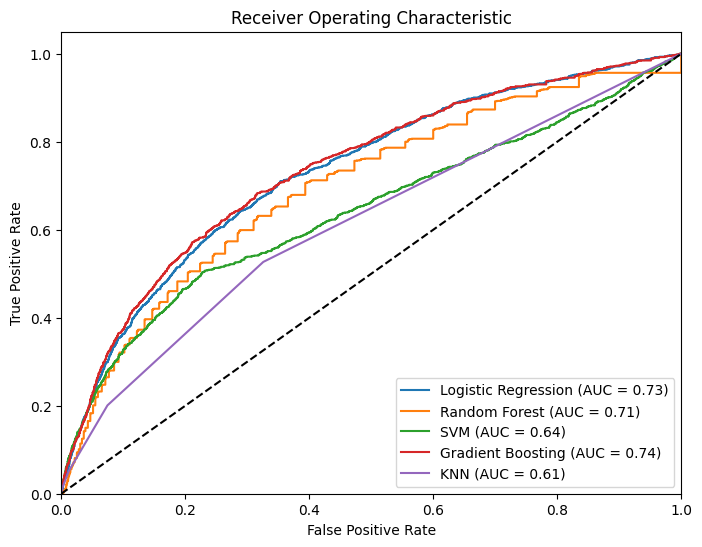

In [ ]:
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()
model_svm = SVC(probability=True)
model_gb = GradientBoostingClassifier()
model_knn = KNeighborsClassifier()

model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_svm.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_knn.fit(X_train, y_train)

probs_lr = model_lr.predict_proba(X_test)[:, 1]
probs_rf = model_rf.predict_proba(X_test)[:, 1]
probs_svm = model_svm.predict_proba(X_test)[:, 1]
probs_gb = model_gb.predict_proba(X_test)[:, 1]
probs_knn = model_knn.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, probs_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probs_rf)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, probs_svm)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, probs_gb)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, probs_knn)

roc_auc_lr = roc_auc_score(y_test, probs_lr)
roc_auc_rf = roc_auc_score(y_test, probs_rf)
roc_auc_svm = roc_auc_score(y_test, probs_svm)
roc_auc_gb = roc_auc_score(y_test, probs_gb)
roc_auc_knn = roc_auc_score(y_test, probs_knn)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', drawstyle='steps-post')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', drawstyle='steps-post')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', drawstyle='steps-post')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})', drawstyle='steps-post')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

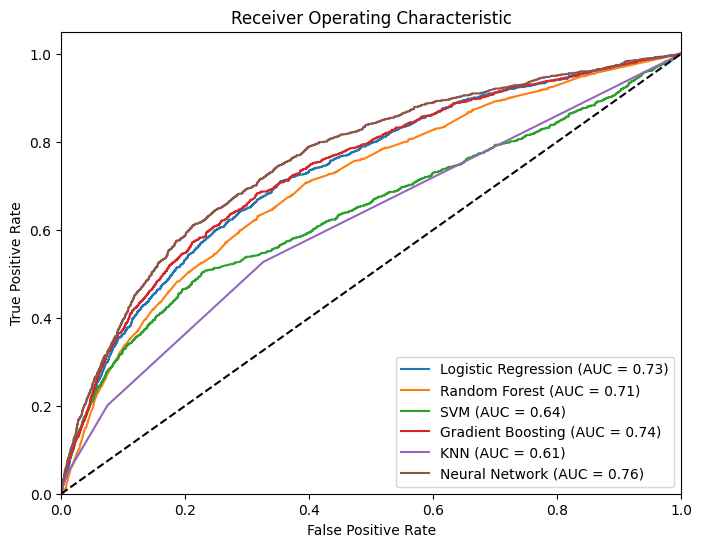

In [ ]:
import sklearn.metrics as metrics

# Initialize the models
models = {
    "Logistic Regression": model_lr,
    "Random Forest": model_rf,
    "SVM": model_svm,
    "Gradient Boosting": model_gb,
    "KNN": model_knn,
    "Neural Network": model
}

# Evaluate and plot the ROC curves for all models
plt.figure(figsize=(8, 6))

for model_name, model in models.items():
    if model_name == "Neural Network":
        # Run the neural network model on the test dataset
        model.eval()
        with torch.no_grad():
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_pred = model(X_test)
            y_pred = y_pred.cpu().detach().numpy()

        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().detach().numpy(), y_pred)

        # Calculate AUC-ROC score
        auc_score = metrics.roc_auc_score(y_test.cpu().detach().numpy(), y_pred)
    else:
        # Predict probabilities using the machine learning model
        model_probs = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model_probs)

        # Calculate AUC-ROC score
        auc_score = metrics.roc_auc_score(y_test, model_probs)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Another optimizers

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2
import random
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
# import shap
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import copy

data = pd.read_csv('df_data (1).csv', sep=";")
data["ГБ новая"] = data["ГБ новая"].replace({'да': 1, 'нет': 0})
data_not_import = data[["startAnswering", "id", "комментарий"]]
data = data.drop(columns=["startAnswering", "id", "комментарий"], axis=1)
categorical_columns = [
                       "сыр, шоко, цитрус", "Физическая ативность", ]
binary_columns = ['Жажда', 'кофеин', 'Зевания', 'ГБ новая', 'Алкоголь'
                  , "боль в шее", "вегетатика", "подташнивает",
                   "мочеиспускание", "Напряжение глаз", "Воды достаточно?", "Были резкие запахи?",
                    "Пропуск приема пищи", "Чувствит кожи головы",
                   "Хотелось шоколада"]
quantitative_columns = ["Тревога", "Депрессия", "Сонливость", "Чувство голода",
                        "Работосособность", "Чувство усталости", "Раздражительность"

                        ]
time_data =['time']
date_data = ["date"]
time_data =['time']
date_data = ["date"]
longest_string_index = data[['time', "Начало боли", "Продолжительность сна", "Окончание боли"]].apply(lambda x: ''.join(x.astype(str)), axis=1).str.len().idxmax()
longest_string = data.loc[longest_string_index, ['time', "Начало боли", "Продолжительность сна", "Окончание боли"]]
data = data.drop(columns=["Боль сейчас"], axis=1)
data = data.drop(data.iloc[:, 27:58],axis = 1)
data = data.drop(columns=["Ожидаете мигрень"], axis=1)
mode_values = data.mode().iloc[0]

# Fill NaN values with mode values in all columns
data = data.fillna(mode_values)
data["ГБ новая"] = data["ГБ новая"].astype(int)
target = data["ГБ новая"]
y = data["ГБ новая"].values
data = data.drop(columns = ["ГБ новая"], axis=1)
binary_columns = ['Жажда', 'кофеин', 'Зевания',  'Алкоголь'
                  , "боль в шее", "вегетатика", "подташнивает",
                   "мочеиспускание", "Напряжение глаз", "Воды достаточно?", "Были резкие запахи?",
                    "Пропуск приема пищи", "Чувствит кожи головы",
                   "Хотелось шоколада"]

for column in binary_columns:
    data[column] = data[column].replace({'да': 1, 'нет': 0})

for column in time_data:
    data[column] = pd.to_datetime(data[column], format='%H:%M')

for column in time_data:
    time_components = [f'{column}_hour', f'{column}_minute']

    data[time_components] = data[column].apply(lambda x: pd.Series([x.hour, x.minute]))
    data_encoded = pd.get_dummies(data, columns=time_components)


data = pd.get_dummies(data, columns=categorical_columns+quantitative_columns+binary_columns)

data["time"] = pd.to_datetime(data["time"]).dt.time
data["datetime"] = pd.to_datetime(data["date"] + " " + data["time"].astype(str))

# Set the datetime column as the index
# data.set_index("datetime", inplace=True)

# Drop unnecessary columns
data.drop(["date", "time", "datetime"], axis=1, inplace=True)

<ipython-input-1-7ab852ae96dd>:34: DtypeWarning: Columns (11,14,20,23,31,33,41,46,49) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('df_data (1).csv', sep=";")


In [ ]:
X = data.iloc[:, 2:].values
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).reshape(-1, 1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.model_selection import StratifiedKFold, train_test_split


class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(109, 180)
        self.batch_norm1 = nn.BatchNorm1d(180)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.hidden2 = nn.Linear(180, 90)
        self.batch_norm2 = nn.BatchNorm1d(90)
        self.output = nn.Linear(90, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if x.size(0) != 1:
            x = self.relu(self.batch_norm1(self.hidden1(x)))
            x = self.dropout(x)
            x = self.relu(self.batch_norm2(self.hidden2(x)))
        else:
            x = self.relu(self.hidden1(x))
            x = self.dropout(x)
            x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(109, 150)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.layer2 = nn.Linear(150, 150)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.layer3 = nn.Linear(150, 100)
        self.act3 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.1)
        self.layer4 = nn.Linear(100, 50)
        self.act4 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.1)
        self.output = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.act3(self.layer3(x))
        x = self.dropout3(x)
        x = self.act4(self.layer4(x))
        x = self.dropout4(x)
        x = self.sigmoid(self.output(x))
        return x

def train_one_epoch(model, X_train, y_train, optimizer, loss_fn, device):
    model.train()
    losses = []
    accuracies = []
    for start in range(0, len(X_train), 10):  # batch_size=10
        X_batch = X_train[start:start+10].to(device)
        y_batch = y_train[start:start+10].to(device)

        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append((y_pred.round() == y_batch).float().mean().item())
    return np.mean(losses), np.mean(accuracies)


def evaluate(model, X_val, y_val, loss_fn, device):
    model.eval()
    with torch.no_grad():
        X_val, y_val = X_val.to(device), y_val.to(device)
        y_pred = model(X_val)
        loss = loss_fn(y_pred, y_val)
        acc = (y_pred.round() == y_val).float().mean().item()
    return loss.item(), acc, y_pred.cpu()


# X and y need to be your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kfold = StratifiedKFold(n_splits=2, shuffle=True)

cv_scores_wide = []
cv_scores_deep = []

for train, test in kfold.split(X_train, y_train):
    model = Wide().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.99)
    loss_fn = nn.BCELoss()

    best_acc = 0
    best_weights = None

    for epoch in range(100):
        train_loss, train_acc = train_one_epoch(model, X_train[train], y_train[train], optimizer, loss_fn, device)
        val_loss, val_acc, _ = evaluate(model, X_train[test], y_train[test], loss_fn, device)
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    model.load_state_dict(best_weights)
    cv_scores_wide.append(best_acc)

    model = Deep().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.99)
    loss_fn = nn.BCELoss()

    best_acc = 0
    best_weights = None

    for epoch in range(100):
        train_loss, train_acc = train_one_epoch(model, X_train[train], y_train[train], optimizer, loss_fn, device)
        val_loss, val_acc, _ = evaluate(model, X_train[test], y_train[test], loss_fn, device)
        if val_acc > best_acc:
            best_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    model.load_state_dict(best_weights)
    cv_scores_deep.append(best_acc)

wide_acc = np.mean(cv_scores_wide)
wide_std = np.std(cv_scores_wide)
deep_acc = np.mean(cv_scores_deep)
deep_std = np.std(cv_scores_deep)
print(f"Wide: {wide_acc * 100:.2f}% (+/- {wide_std * 100:.2f}%)")
print(f"Deep: {deep_acc * 100:.2f}% (+/- {deep_std * 100:.2f}%)")

if wide_acc > deep_acc:
    model = Wide().to(device)
else:
    model = Deep().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.99)
loss_fn = nn.BCELoss()
best_acc = 0
best_weights = None

for epoch in range(100):
    train_loss, train_acc = train_one_epoch(model, X_train, y_train, optimizer, loss_fn, device)
    val_loss, val_acc, _ = evaluate(model, X_test, y_test, loss_fn, device)
    if val_acc > best_acc:
        best_acc = val_acc
        best_weights = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

model.load_state_dict(best_weights)
final_val_loss, final_val_acc, _ = evaluate(model, X_test, y_test, loss_fn, device)
print(f"Final Test Loss: {final_val_loss:.4f}, Final Test Acc: {final_val_acc:.4f}")

Epoch 1: Train Loss: 0.8613, Train Acc: 0.8814, Val Loss: 0.5228, Val Acc: 0.8909
Epoch 2: Train Loss: 0.3960, Train Acc: 0.8892, Val Loss: 0.5343, Val Acc: 0.8909
Epoch 3: Train Loss: 0.3951, Train Acc: 0.8895, Val Loss: 0.5311, Val Acc: 0.8909
Epoch 4: Train Loss: 0.3948, Train Acc: 0.8895, Val Loss: 0.5312, Val Acc: 0.8909
Epoch 5: Train Loss: 0.3948, Train Acc: 0.8895, Val Loss: 0.5312, Val Acc: 0.8909
Epoch 6: Train Loss: 0.3948, Train Acc: 0.8895, Val Loss: 0.5312, Val Acc: 0.8909
Epoch 7: Train Loss: 0.3948, Train Acc: 0.8895, Val Loss: 0.5312, Val Acc: 0.8909
Epoch 8: Train Loss: 0.3951, Train Acc: 0.8895, Val Loss: 0.5317, Val Acc: 0.8909
Epoch 9: Train Loss: 0.3954, Train Acc: 0.8895, Val Loss: 0.5304, Val Acc: 0.8909
Epoch 10: Train Loss: 0.3947, Train Acc: 0.8895, Val Loss: 0.5312, Val Acc: 0.8909
Epoch 11: Train Loss: 0.3948, Train Acc: 0.8895, Val Loss: 0.5312, Val Acc: 0.8909
Epoch 12: Train Loss: 0.3948, Train Acc: 0.8895, Val Loss: 0.5312, Val Acc: 0.8909
Epoch 13: Tra

KeyboardInterrupt: ignored

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=cd3426383fb2f8d70052dc5d23d6f1f0d9a4ce378e508ce69478207c63d834a9
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [ ]:
import torch
from torchviz import make_dot

# Instantiate the models
wide_model = Wide()
deep_model = Deep()

# Create a random tensor matching the input size
x = torch.randn(1, 109)

# Make the forward pass and generate the computational graph
y_wide = wide_model(x)
y_deep = deep_model(x)

# Visualize the computational graph
dot_wide = make_dot(y_wide.mean(), params=dict(wide_model.named_parameters()))
dot_deep = make_dot(y_deep.mean(), params=dict(deep_model.named_parameters()))

# To save the file as a .png:
dot_wide.format = 'png'
dot_wide.render(filename='wide_model')

dot_deep.format = 'png'
dot_deep.render(filename='deep_model')


'deep_model.png'

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
<ipython-input-9-118364c313df>:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train, y_train)
/usr

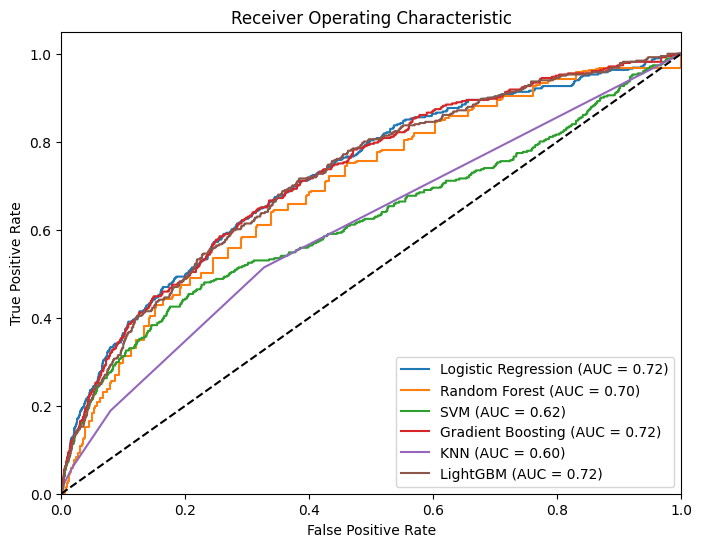

In [ ]:
model_lr = LogisticRegression()
model_rf = RandomForestClassifier()
model_svm = SVC(probability=True)
model_gb = GradientBoostingClassifier()
model_knn = KNeighborsClassifier()
model_lgbm = LGBMClassifier()

model_lr.fit(X_train, y_train)
model_rf.fit(X_train, y_train)
model_svm.fit(X_train, y_train)
model_gb.fit(X_train, y_train)
model_knn.fit(X_train, y_train)
model_lgbm.fit(X_train, y_train)

probs_lr = model_lr.predict_proba(X_test)[:, 1]
probs_rf = model_rf.predict_proba(X_test)[:, 1]
probs_svm = model_svm.predict_proba(X_test)[:, 1]
probs_gb = model_gb.predict_proba(X_test)[:, 1]
probs_knn = model_knn.predict_proba(X_test)[:, 1]
probs_lgbm = model_lgbm.predict_proba(X_test)[:, 1]

fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, probs_lr)
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, probs_rf)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, probs_svm)
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, probs_gb)
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_test, probs_knn)
fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, probs_lgbm)

roc_auc_lr = roc_auc_score(y_test, probs_lr)
roc_auc_rf = roc_auc_score(y_test, probs_rf)
roc_auc_svm = roc_auc_score(y_test, probs_svm)
roc_auc_gb = roc_auc_score(y_test, probs_gb)
roc_auc_knn = roc_auc_score(y_test, probs_knn)
roc_auc_lgbm = roc_auc_score(y_test, probs_lgbm)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})', drawstyle='steps-post')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', drawstyle='steps-post')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', drawstyle='steps-post')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})', drawstyle='steps-post')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')
plt.plot(fpr_lgbm, tpr_lgbm, label=f'LightGBM (AUC = {roc_auc_lgbm:.2f})', drawstyle='steps-post')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Predict classes
y_pred_lr = model_lr.predict(X_test)
y_pred_rf = model_rf.predict(X_test)
y_pred_svm = model_svm.predict(X_test)
y_pred_gb = model_gb.predict(X_test)
y_pred_knn = model_knn.predict(X_test)
y_pred_lgbm = model_lgbm.predict(X_test)

# Print classification reports
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))
print("SVM:\n", classification_report(y_test, y_pred_svm))
print("Gradient Boosting:\n", classification_report(y_test, y_pred_gb))
print("KNN:\n", classification_report(y_test, y_pred_knn))
print("LightGBM:\n", classification_report(y_test, y_pred_lgbm))


Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.90      0.99      0.94      3103
         1.0       0.54      0.06      0.10       381

    accuracy                           0.89      3484
   macro avg       0.72      0.53      0.52      3484
weighted avg       0.86      0.89      0.85      3484

Random Forest:
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94      3103
         1.0       0.28      0.04      0.06       381

    accuracy                           0.88      3484
   macro avg       0.59      0.51      0.50      3484
weighted avg       0.83      0.88      0.84      3484

SVM:
               precision    recall  f1-score   support

         0.0       0.89      1.00      0.94      3103
         1.0       0.00      0.00      0.00       381

    accuracy                           0.89      3484
   macro avg       0.45      0.50      0.47      3484
weighted avg       0.79      0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


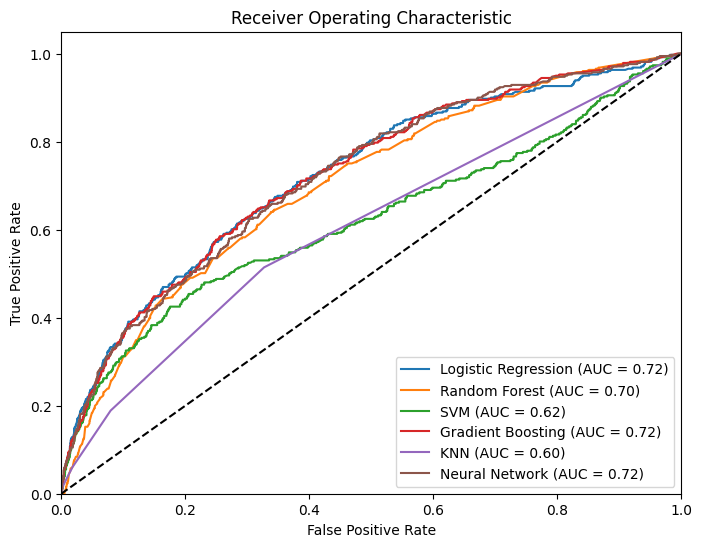

In [ ]:
import sklearn.metrics as metrics

# Initialize the models
models = {
    "Logistic Regression": model_lr,
    "Random Forest": model_rf,
    "SVM": model_svm,
    "Gradient Boosting": model_gb,
    "KNN": model_knn,
    "Neural Network": model
}

# Evaluate and plot the ROC curves for all models
plt.figure(figsize=(8, 6))

for model_name, model in models.items():
    if model_name == "Neural Network":
        # Run the neural network model on the test dataset
        model.eval()
        with torch.no_grad():
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_pred = model(X_test)
            y_pred = y_pred.cpu().detach().numpy()

        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().detach().numpy(), y_pred)

        # Calculate AUC-ROC score
        auc_score = metrics.roc_auc_score(y_test.cpu().detach().numpy(), y_pred)
    else:
        # Predict probabilities using the machine learning model
        model_probs = model.predict_proba(X_test)[:, 1]

        # Calculate ROC curve
        fpr, tpr, thresholds = metrics.roc_curve(y_test, model_probs)

        # Calculate AUC-ROC score
        auc_score = metrics.roc_auc_score(y_test, model_probs)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Test possible optimizers

In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam, RMSprop, Adadelta, Adagrad, AdamW, ASGD
import copy
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split

class Wide(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(109, 180)
        self.batch_norm1 = nn.BatchNorm1d(180)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.hidden2 = nn.Linear(180, 90)
        self.batch_norm2 = nn.BatchNorm1d(90)
        self.output = nn.Linear(90, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if x.size(0) != 1:
            x = self.relu(self.batch_norm1(self.hidden1(x)))
            x = self.dropout(x)
            x = self.relu(self.batch_norm2(self.hidden2(x)))
        else:
            x = self.relu(self.hidden1(x))
            x = self.dropout(x)
            x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x


class Deep(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(109, 150)
        self.act1 = nn.LeakyReLU()
        self.dropout1 = nn.Dropout(0.1)
        self.layer2 = nn.Linear(150, 150)
        self.act2 = nn.LeakyReLU()
        self.dropout2 = nn.Dropout(0.1)
        self.layer3 = nn.Linear(150, 100)
        self.act3 = nn.LeakyReLU()
        self.dropout3 = nn.Dropout(0.1)
        self.layer4 = nn.Linear(100, 50)
        self.act4 = nn.LeakyReLU()
        self.dropout4 = nn.Dropout(0.1)
        self.output = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.dropout2(x)
        x = self.act3(self.layer3(x))
        x = self.dropout3(x)
        x = self.act4(self.layer4(x))
        x = self.dropout4(x)
        x = self.sigmoid(self.output(x))
        return x


def train_one_epoch(model, X_train, y_train, optimizer, loss_fn, device):
    model.train()
    losses = []
    accuracies = []
    for start in range(0, len(X_train), 10):  # batch_size=10
        X_batch = X_train[start:start+10].to(device)
        y_batch = y_train[start:start+10].to(device)

        optimizer.zero_grad()

        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        accuracies.append((y_pred.round() == y_batch).float().mean().item())
    return np.mean(losses), np.mean(accuracies)


def evaluate(model, X_val, y_val, loss_fn, device):
    model.eval()
    with torch.no_grad():
        X_val, y_val = X_val.to(device), y_val.to(device)
        y_pred = model(X_val)
        loss = loss_fn(y_pred, y_val)
        acc = (y_pred.round() == y_val).float().mean().item()
    return loss.item(), acc, y_pred.cpu()


# X and y need to be your dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

kfold = StratifiedKFold(n_splits=5, shuffle=True)

# List of optimizers to test
import itertools

# List of optimizers and hyperparameters to test
optimizer_hyperparameters = [
    (SGD, [{'lr': lr, 'momentum': momentum} for lr, momentum in itertools.product([0.1, 0.01, 0.001], [0.9, 0.99])]),
    (Adam, [{'lr': lr} for lr in [0.1, 0.01, 0.001]]),
    (RMSprop, [{'lr': lr} for lr in [0.1, 0.01, 0.001]]),
    (Adadelta, [{'lr': lr} for lr in [1.0, 0.1, 0.01]]),
    (Adagrad, [{'lr': lr} for lr in [0.1, 0.01, 0.001]]),
    (AdamW, [{'lr': lr} for lr in [0.1, 0.01, 0.001]]),
    (ASGD, [{'lr': lr} for lr in [0.1, 0.01, 0.001]]),
]

# Dictionary to store the results
results = {
    'optimizer': [],
    'hyperparameters': [],
    'model_type': [],
    'cv_scores': [],
}

# Main loop to test each optimizer and set of hyperparameters
for optim_class, hyperparameters in optimizer_hyperparameters:
    print(f'Testing optimizer: {optim_class.__name__}')

    for hyperparameter in hyperparameters:
        print(f'Testing hyperparameters: {hyperparameter}')

        cv_scores_wide = []
        cv_scores_deep = []

        for train, test in kfold.split(X_train, y_train):
            model = Wide().to(device)
            optimizer = optim_class(model.parameters(), **hyperparameter)
            loss_fn = nn.BCELoss()

            best_acc = 0
            best_weights = None

            for epoch in range(10):
                train_loss, train_acc = train_one_epoch(model, X_train[train], y_train[train], optimizer, loss_fn, device)
                val_loss, val_acc, _ = evaluate(model, X_train[test], y_train[test], loss_fn, device)
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_weights = copy.deepcopy(model.state_dict())

            model.load_state_dict(best_weights)
            cv_scores_wide.append(best_acc)

            model = Deep().to(device)
            optimizer = optim_class(model.parameters(), **hyperparameter)
            loss_fn = nn.BCELoss()

            best_acc = 0
            best_weights = None

            for epoch in range(10):
                train_loss, train_acc = train_one_epoch(model, X_train[train], y_train[train], optimizer, loss_fn, device)
                val_loss, val_acc, _ = evaluate(model, X_train[test], y_train[test], loss_fn, device)
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_weights = copy.deepcopy(model.state_dict())

            model.load_state_dict(best_weights)
            cv_scores_deep.append(best_acc)

        results['optimizer'].extend([optim_class.__name__, optim_class.__name__])
        results['hyperparameters'].extend([hyperparameter, hyperparameter])
        results['model_type'].extend(['Wide', 'Deep'])
        results['cv_scores'].extend([cv_scores_wide, cv_scores_deep])

# Convert results to DataFrame
import pandas as pd

results_df = pd.DataFrame(results)

# Print the best optimizer and hyperparameters
best_index = results_df['cv_scores'].apply(np.mean).idxmax()
best_optimizer = results_df.loc[best_index, 'optimizer']
best_hyperparameters = results_df.loc[best_index, 'hyperparameters']
best_cv_score = np.mean(results_df.loc[best_index, 'cv_scores'])
print(f'Best optimizer: {best_optimizer} with hyperparameters: {best_hyperparameters} and CV score: {best_cv_score}')


Testing optimizer: SGD
Testing hyperparameters: {'lr': 0.1, 'momentum': 0.9}
Testing hyperparameters: {'lr': 0.1, 'momentum': 0.99}
Testing hyperparameters: {'lr': 0.01, 'momentum': 0.9}
Testing hyperparameters: {'lr': 0.01, 'momentum': 0.99}
Testing hyperparameters: {'lr': 0.001, 'momentum': 0.9}
Testing hyperparameters: {'lr': 0.001, 'momentum': 0.99}
Testing optimizer: Adam
Testing hyperparameters: {'lr': 0.1}
Testing hyperparameters: {'lr': 0.01}
Testing hyperparameters: {'lr': 0.001}
Testing optimizer: RMSprop
Testing hyperparameters: {'lr': 0.1}
Testing hyperparameters: {'lr': 0.01}
Testing hyperparameters: {'lr': 0.001}
Testing optimizer: Adadelta
Testing hyperparameters: {'lr': 1.0}
Testing hyperparameters: {'lr': 0.1}
Testing hyperparameters: {'lr': 0.01}
Testing optimizer: Adagrad
Testing hyperparameters: {'lr': 0.1}
Testing hyperparameters: {'lr': 0.01}
Testing hyperparameters: {'lr': 0.001}
Testing optimizer: AdamW
Testing hyperparameters: {'lr': 0.1}
Testing hyperparameter